# Mutation Classification
This notebook implements a complete pipeline to classify cancer patients based on their genomic mutation profiles.
Using feature engineering, visualization, and a support vector machine classifier, we aim to distinguish between LUSC and HNSC subtypes.
The code includes data loading, processing, training, and final prediction for submission.

## 📁 project_root
Data should be placed inside root/data folder, as follows:
```bash
project_root/
# ├── data/
# │   ├── train_muts_data.csv
# │   ├── test_muts_data.csv
# │   ├── train_meth_data.csv
# │   ├── test_meth_data.csv
# │   ├── train_feats.csv
# │   ├── test_feats.csv
# │   ├── 100_genes.csv
# │   ├── E_cool_ORF.csv
# ├── plots/
# │   ├──mutation_types_ordered.png
# ├── predictions/
# │   ├── results_muts.csv
# │   ├── results_meth.csv
# ├── mutation_classifier.ipynb
```
## ✅ Install required packages
```bash
!pip install pandas numpy matplotlib scikit-learn
```
## ⚙️ Config


In [1]:
from pathlib import Path

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
PLOT_DIR = PROJECT_ROOT / "plots"

MUTS_TRAIN_FILE = DATA_DIR / "train_muts_data.csv"
MUTS_TEST_FILE = DATA_DIR / "test_muts_data.csv"
METH_TRAIN_FILE = DATA_DIR / "train_meth_data.csv"
METH_TEST_FILE = DATA_DIR / "test_meth_data.csv"

PREDICTION_DIR = PROJECT_ROOT / "predictions"

TRAIN_FEATURE_FILE = DATA_DIR / "train_feats.csv"
TEST_FEATURE_FILE = DATA_DIR / "test_feats.csv"

GENE_LIST = DATA_DIR / "100_genes.csv"

SILENT_CLASSES = {"Silent",
                  "Synonymous",
                  "Intron",
                  "3'UTR",
                  "5'UTR",
                  "IGR",
                  "Flank",
                  "FlankNC"}

# All others -> Non-silent
GROUP_MAP = [
    "Missense_Mutation",
    "In_Frame_Del",
    "Nonsense_Mutation",
    "Frame_Shift_Del",
    "Frame_Shift_Ins",
    "In_Frame_Ins",
    "Translation_Start_Site",
    "Nonstop_Mutation",
    "Splice_Region",
    "3'UTR",
    "5'UTR",
    "Intron",
    "Splice_Site",
    "Silent",
    "3'Flank",
    "5'Flank"
]

## Task 1: Classifier Based on Mutation Features
### Section a:
#### ✨ Feature Overview
**build_basic_features** yields the mandatory feature set requested in the assignment:<br>
  • `total_mutations` - overall mutation burden per patient<br>
  • `type_<mutation> - ` count of every `Variant_Classification` value<br>
  • `gene_<symbol>` = mutation count for each of the 100 selected genes<br>

### Section b:
**build_extra_features** then enriches the matrix with the two ratio features advocated in the npj paper:<br>
  • `silent_frac` - regulatory “silent” mutational load, capturing non‑coding pressure<br>
  • `del_ratio` - deletion enrichment signal, known to differ across squamous subtypes<br>
Including these ratios follows the paper’s finding that silent load and deletion bias provide compact,<br>
informative signals that boost classifier performance.<br>

NOTE: we add to these features the given features by concatenation

In [2]:
import pandas as pd


def build_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build basic features dataframe.
    :param df: pandas dataframe - "train_muts_data.csv".
    return: basic features dataframe:
    [total_mutations], [type_counts: for each mutation], [gene_counts, for each mutation].
    """
    order = pd.Index(df['case_id'].unique())

    total_mutations = (
        df.groupby('case_id', sort=False).size()
        .reindex(order)
        .rename('total_mutations')
    )

    type_counts = (
        pd.crosstab(df['case_id'], df['Variant_Classification'])
        .add_prefix('type_')
        .reindex(order, fill_value=0)
    )

    gene_counts = (
        pd.crosstab(df['case_id'], df['Gene_name'])
        .add_prefix('gene_')
        .reindex(order, fill_value=0)
    )

    basic_features = pd.concat(
        [total_mutations, type_counts, gene_counts],
        axis=1
    )

    return basic_features


def build_extra_features(df: pd.DataFrame, basic_features: pd.DataFrame) -> pd.DataFrame:
    """
    Build extra features dataframe.
    :param df: "train_muts_data.csv"
    :param basic_features:  basic features dataframe.
    :return: extra features dataframe with previous:
    [total_mutations], [type_counts: for each mutation], [gene_counts, for each mutation].=
    , [silent_frac], [del_ratio].
    """
    order = pd.Index(df['case_id'].unique())

    silent_mask = df['Variant_Classification'].isin(SILENT_CLASSES)
    silent_counts = (
        df[silent_mask].groupby('case_id', sort=False).size()
        .reindex(order, fill_value=0)
    )
    silent_frac = (silent_counts / basic_features['total_mutations']).rename('silent_frac')

    alt2 = df['Tumor_Seq_Allele2'].fillna('').str.upper()
    ref = df['Reference_Allele'].fillna('').str.upper()
    del_mask = (alt2 == '-') | (ref.str.len() > alt2.str.len())

    del_counts = (
        df[del_mask].groupby('case_id', sort=False).size()
        .reindex(order, fill_value=0)
    )
    del_ratio = (del_counts / basic_features['total_mutations']).rename('del_ratio')

    features = pd.concat(
        [basic_features, silent_frac, del_ratio],
        axis=1
    )

    count_cols = features.columns.difference(['silent_frac', 'del_ratio'])
    features[count_cols] = features[count_cols].fillna(0).astype(int)

    return features

First, compute the basic features and concat them to the given features.<br>
The Separation is done to test whether there is an improvement by including the extra features.

In [3]:
import pandas as pd

# compute basic features
train_df = pd.read_csv(MUTS_TRAIN_FILE)

train_basic_features = build_basic_features(train_df)

# load given features
given_features = pd.read_csv(TRAIN_FEATURE_FILE)
given_features = given_features.select_dtypes(include=["number"])

# concat
train_basic_features = pd.concat([given_features.reset_index(drop=True),
                                  train_basic_features.reset_index(drop=True)
                                  ], axis=1)

# separate labels from the data
train_basic_features = train_basic_features.drop(columns=["case_id", "Label"], errors="ignore")
order = train_df["case_id"].unique()

labels = (
    train_df.groupby("case_id", sort=False)["Label"].first()
    .reindex(order)
)

### Section c:
#### 🔍 Mutation Distribution Plot and Visualization
This utility combines mutation records from both train and test datasets,<br>
filters relevant mutation types (based on GROUP_MAP), and plots their counts<br>
in a predefined biologically meaningful order. The output is saved as<br>
'mutation_types_ordered.png' and can optionally be displayed interactively.<br>

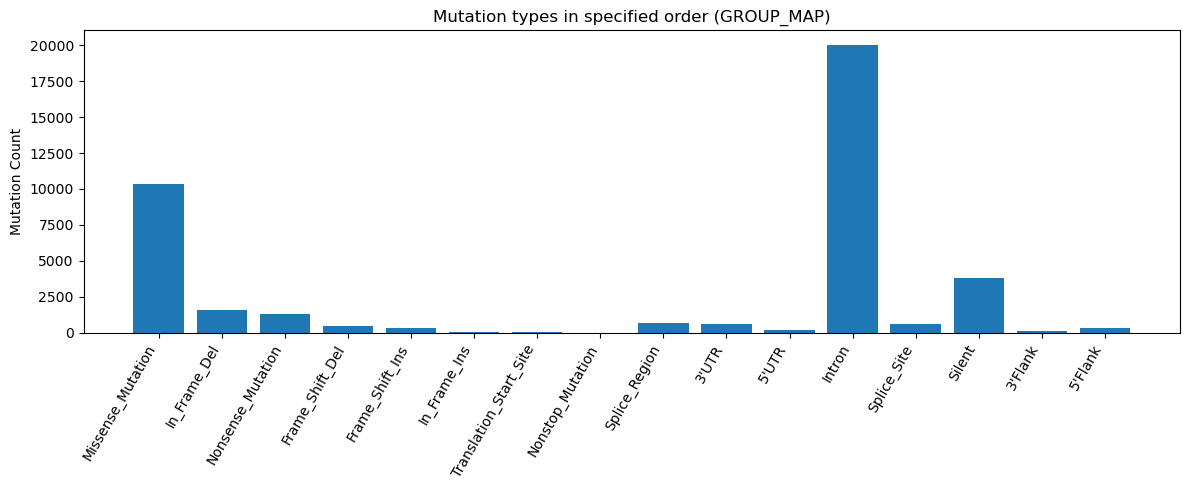

Plot saved to: C:\Users\danie\PycharmProjects\computational_genomic\plots\mutation_types_ordered.png


<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_mutation_distribution(train_df: pd.DataFrame, test_df: pd.DataFrame, show=False) -> None:
    """
    Create and save a bar plot showing mutation counts by Variant_Classification
    in a specified order (TCGA-style). Combines train and test datasets.
    """
    out_file = PLOT_DIR / "mutation_types_ordered.png"
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

    df = pd.concat([train_df, test_df], ignore_index=True)

    mask = df["Group"] = df["Variant_Classification"].isin(GROUP_MAP)
    df_filtered = df[mask]

    counts = (df_filtered["Variant_Classification"]
              .value_counts()
              .reindex(GROUP_MAP, fill_value=0)
              .rename_axis("VC")
              .reset_index(name="Count"))

    plt.figure(figsize=(12, 5))
    plt.bar(counts["VC"], counts["Count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Mutation Count")
    plt.title("Mutation types in specified order (GROUP_MAP)")
    plt.tight_layout()

    if show:
        plt.show()

    plt.savefig(out_file, dpi=150)
    print(f"Plot saved to: {out_file}")


test_df = pd.read_csv(MUTS_TEST_FILE)
plot_mutation_distribution(train_df, test_df, show=True)

This plot displays the distribution of mutation types (Variant_Classification) across all patients,<br>
using a predefined order that mirrors the presentation in the reference paper.<br>
By aligning the categories with GROUP_MAP, we ensure visual consistency with the npj figure, making it easier to compare trends across datasets.<br>
This overview helps confirm that the mutation landscape in our cohort is comparable to that described in the original study.<br>

Next, an excellent way to represent the data in 2-D is via PCA.<br>
Although it does not look like the data is linearly separable by a support vector,<br>
The data do have a uniform and consistent structure.

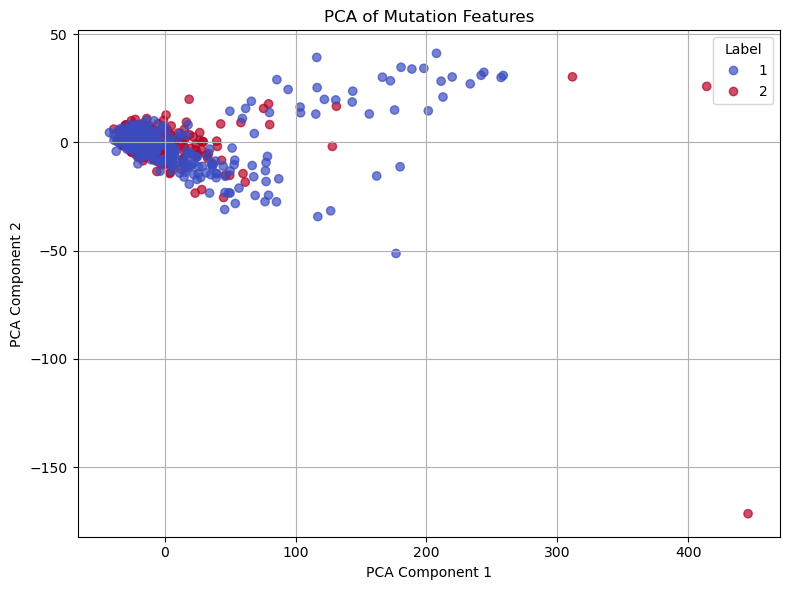

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_basic_features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Mutation Features")
plt.legend(*scatter.legend_elements(), title="Label")
plt.grid(True)
plt.tight_layout()
plt.show()


To see how the extra features, silent_frac and del_ratio are behaving,<br>
plot them in a scatter plot with corresponding labels.<br>
Sadly, we can infer that the new features will not add information for the classification to improve,<br>
as will be shown in the next section.<br>
Overall, we tried to create even more different features - with no gains.<br>
Hence, continued with a simple build.

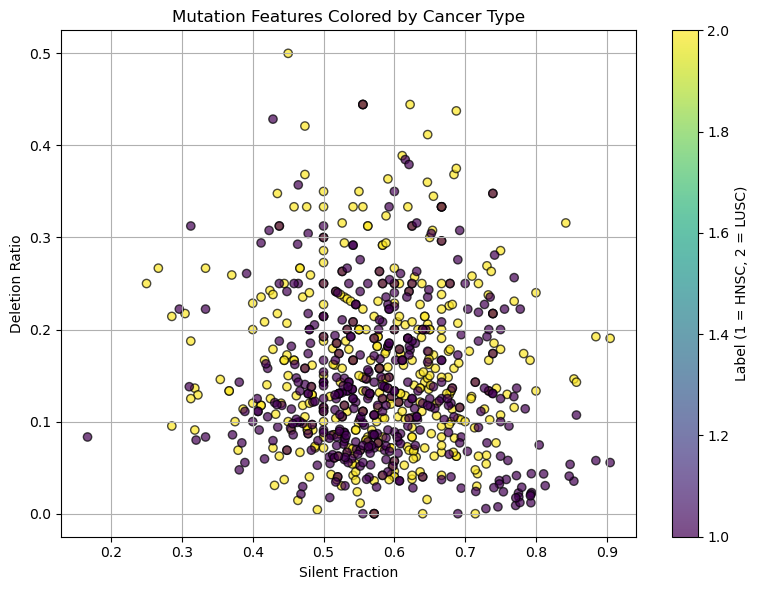

In [6]:
import matplotlib.pyplot as plt

train_basic_features = build_basic_features(train_df)
train_extra_features = build_extra_features(train_df, train_basic_features)

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_extra_features['silent_frac'],
    train_extra_features['del_ratio'],
    c=labels,
    cmap='viridis',  # or 'coolwarm', 'plasma', etc.
    alpha=0.7,
    edgecolors='k'
)

plt.xlabel('Silent Fraction')
plt.ylabel('Deletion Ratio')
plt.title('Mutation Features Colored by Cancer Type')
plt.colorbar(scatter, label='Label (1 = HNSC, 2 = LUSC)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Section d - Fitting the Data
🌳 Random forest model was chosen since it prevails SVM with different hyperparameters (test was omitted for clearness).<br>
A PCA option was added since the data is sparse.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd


class RandomForestClassifierWrapper:
    def __init__(self, n_estimators=200, random_state=42, use_pca=False, n_components=None):
        self.use_pca = use_pca
        self.n_components = n_components
        self.scaler = StandardScaler()
        if use_pca:
            self.pca = PCA(n_components=n_components)
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        self.fitted = False

    def fit(self, x: pd.DataFrame, y: pd.Series):
        x_scaled = self.scaler.fit_transform(x)
        if self.use_pca:
            x_scaled = self.pca.fit_transform(x_scaled)
        self.model.fit(x_scaled, y)
        self.fitted = True

    def predict(self, x: pd.DataFrame) -> pd.Series:
        if not self.fitted:
            raise RuntimeError("Model must be fitted before prediction.")

        x_scaled = self.scaler.transform(x)

        if self.use_pca:
            x_scaled = self.pca.transform(x_scaled)

        return pd.Series(self.model.predict(x_scaled), index=x.index)

    def evaluate(self, x: pd.DataFrame, y: pd.Series) -> float:
        y_pred = self.predict(x)
        return 1 - accuracy_score(y, y_pred)


This Random Forest class by SKlearn can leverage PCA to preform dimension redaction to squeeze the sparsity into a dense representation.<br> Despite the sparsity, the result with PCA are worse.<br>

K-fold validation set is created to mimic a test set.<br>
Exactly 20% from the data is dedicated to validation set.<br>

Eventually, the model fits the data.

In [8]:
from sklearn.model_selection import train_test_split

clf = RandomForestClassifierWrapper(use_pca=False, n_components=200)

x_train, x_val, y_train, y_val = train_test_split(train_basic_features,
                                                  labels,
                                                  test_size=0.2,
                                                  stratify=labels,
                                                  random_state=1
                                                  )

clf.fit(x_train, y_train)

### Section e - Validation Set Error
✅ The result are great!

In [9]:
df_known_test = pd.DataFrame({
    "predict_label": clf.predict(x_val),
    "Label": y_val
})
error = sum(df_known_test["Label"] != df_known_test["predict_label"]) / len(df_known_test)
print(f"Validation Error Rate: {error:.4f}")

Validation Error Rate: 0.3540


Despite the current error rate, we try to improve using extra features computed in section b:

In [10]:
import pandas as pd

train_df = pd.read_csv(MUTS_TRAIN_FILE)

# compute basic and extra features
train_basic_features = build_basic_features(train_df)
train_extra_features = build_extra_features(train_df, train_basic_features)

# load given features
given_features = pd.read_csv(TRAIN_FEATURE_FILE)
given_features = given_features.select_dtypes(include=["number"])

# concat
train_extra_features = pd.concat([given_features.reset_index(drop=True),
                                  train_extra_features.reset_index(drop=True)
                                  ], axis=1)

# separate labels from the data
train_extra_features = train_extra_features.drop(columns=["case_id", "Label"], errors="ignore")
order = train_df["case_id"].unique()

labels = (
    train_df.groupby("case_id", sort=False)["Label"].first()
    .reindex(order)
)

from sklearn.model_selection import train_test_split

clf = RandomForestClassifierWrapper(use_pca=False, n_components=100)

x_train, x_val, y_train, y_val = train_test_split(train_basic_features,
                                                  labels,
                                                  test_size=0.2,
                                                  stratify=labels,
                                                  random_state=1
                                                  )

clf.fit(x_train, y_train)

df_known_test = pd.DataFrame({
    "predict_label": clf.predict(x_val),
    "Label": y_val,
})
error = sum(df_known_test["Label"] != df_known_test["predict_label"]) / len(df_known_test)
print(f"Validation Error Rate: {error:.4f}")

Validation Error Rate: 0.3540


Sadly, the results are identical - but still amazing!

### Section f - Test set
🧪 Finally, predict the caner type for the test cases

In [11]:
test_df = pd.read_csv(MUTS_TEST_FILE)

test_basic_features = build_basic_features(test_df)
test_extra_features = build_extra_features(test_df, test_basic_features)

given_features = pd.read_csv(TEST_FEATURE_FILE)
given_features = given_features.select_dtypes(include=["number"])

test_extra_features = pd.concat([given_features.reset_index(drop=True),
                                 test_extra_features.reset_index(drop=True)
                                 ], axis=1)

# ensure test features match train columns
for col in x_train.columns:
    if col not in test_extra_features.columns:
        test_extra_features[col] = 0

# remove unexpected columns
test_extra_features = test_extra_features[x_train.columns]

pred = clf.predict(test_extra_features)

label_map = {1: "HNSC", 2: "LUSC"}
pred_named = pred.map(label_map)

case_ids = test_df["case_id"].unique()

predicted_df = pd.DataFrame({"case_id": case_ids,
                             "predicted_label": pred_named.values
                             })
print(predicted_df.head(10))


                                case_id predicted_label
0  03b57fee-55c7-4873-b7ef-e29abd98863a            LUSC
1  0425cb44-66af-4e25-afcb-cacccc2f1179            LUSC
2  044579ef-16a6-4f00-b951-edc423d8a14f            LUSC
3  05d4d9c7-fb6f-439a-bb97-f0e2737a7773            HNSC
4  0858c8b7-e2eb-4461-b65e-9d476029ad8d            LUSC
5  0ab8d063-62b4-4d47-82aa-e3351a60029d            HNSC
6  0cca2b84-62bb-41c6-a65d-c27e4e98af78            HNSC
7  0de19185-3517-4e30-925b-7eb1f5079ec2            LUSC
8  0e515ab8-99f9-43d9-a621-8fe9ede828ec            LUSC
9  0f25d7fd-fc7c-4563-a8bd-80b5e0c32ea2            LUSC


Save the predictions in CVS:

In [12]:
import os

os.makedirs(PREDICTION_DIR, exist_ok=True)

output_path = os.path.join(PREDICTION_DIR, "predictions.csv")
predicted_df.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")

Predictions saved to: C:\Users\danie\PycharmProjects\computational_genomic\predictions\predictions.csv


## Task 2: Classifier Based on Mutation Features
### Section a:
#### ✨ Feature Overview
**build_basic_features** yields the mandatory feature set requested in the assignment:<br>
  • `avg_methylation` - average methylation value for each prob related to a certain gene.<br>


### Section b:
**build_extra_features** then enriches the matrix with the two ratio features advocated in the npj paper:<br>
  • `meth_var_per_patient` - variance of all methylation β-values for each patient,<br>
   quantifying heterogeneity of methylation patterns across loci.<br>
   High variance may reflect epigenetic instability, which is often correlated with cancer progression and subtype differentiation. <br>
  • `meth_promoter_density` - fraction of hypermethylated CpG sites in promoter regions (or approximated upstream gene regions).<br>
Promoter hypermethylation can lead to gene silencing and thus plays a central role in tumorigenesis.<br>
Capturing this density provides a signal about epigenetic silencing across tumor genomes.<br>

NOTE: we add to these features the given features by concatenation

In [13]:
def build_methylation_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build methylation basic features dataframe.
    :param df: "train_meth.csv"
    :return: basic features dataframe:
    [avg_methylation]
    """
    df = df.dropna(subset=['matching_genes'])
    gene_avg = (df.groupby(['case_id', 'matching_genes'])['beta_val']
                .mean()
                .unstack(fill_value=0)
                .add_prefix('meth_')
                )
    return gene_avg


def build_methylation_extra_features(df: pd.DataFrame, basic_features: pd.DataFrame) -> pd.DataFrame:
    """
    Build methylation extra features dataframe.
    :param df: "train_meth.csv" / "test_meth.csv"
    :return: extra features dataframe:
    [meth_var], [promoter_density]
    """
    meth_var = df.groupby('case_id')['beta_val'].var().rename('meth_var_per_patient')

    is_promoter = df['matching_genes'].str.contains('^P|FLANK|flank|prom', case=False, na=False)
    high_beta = df['beta_val'] > 0.7
    hyper_meth = df[is_promoter & high_beta].groupby('case_id').size()
    total_meth = df.groupby('case_id').size()
    promoter_density = (hyper_meth / total_meth).fillna(0).rename('meth_promoter_density')

    extra = pd.concat([meth_var, promoter_density], axis=1)
    return basic_features.join(extra, how='left').fillna(0)

First, compute the basic features and concat them to the given features.<br>
Again, The Separation is done to test whether there is an improvement by including the extra features.

In [14]:
import pandas as pd

# compute basic features
train_df = pd.read_csv(METH_TRAIN_FILE)

train_basic_features = build_methylation_basic_features(train_df)
train_extra_features = build_methylation_extra_features(train_df, train_basic_features)

# load given features
given_features = pd.read_csv(TRAIN_FEATURE_FILE)
given_features = given_features.select_dtypes(include=["number"])

# concat
train_basic_features = pd.concat([given_features.reset_index(drop=True),
                                  train_basic_features.reset_index(drop=True)
                                  ], axis=1)

# enrich with extra features
train_basic_features = build_methylation_extra_features(train_df, train_basic_features)

# separate labels from the data
train_basic_features = train_basic_features.drop(columns=["case_id", "Label"], errors="ignore")
order = train_df["case_id"].unique()

labels = (
    train_df.groupby("case_id", sort=False)["Label"].first()
    .reindex(order)
)


Using PCA to visualize the data, we can infer that the given features are dominant.<br>
Thus, we will classify the data with the extra features only.

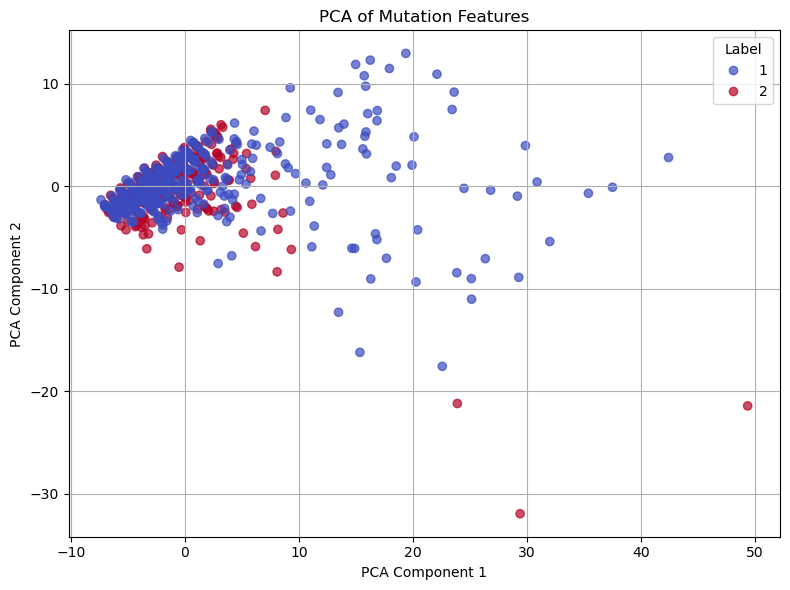

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_basic_features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Mutation Features")
plt.legend(*scatter.legend_elements(), title="Label")
plt.grid(True)
plt.tight_layout()
plt.show()

To see how the extra features, **meth_promoter_density** and **meth_var_per_patient** are behaving,<br>
plot them in a scatter plot with corresponding labels.<br>

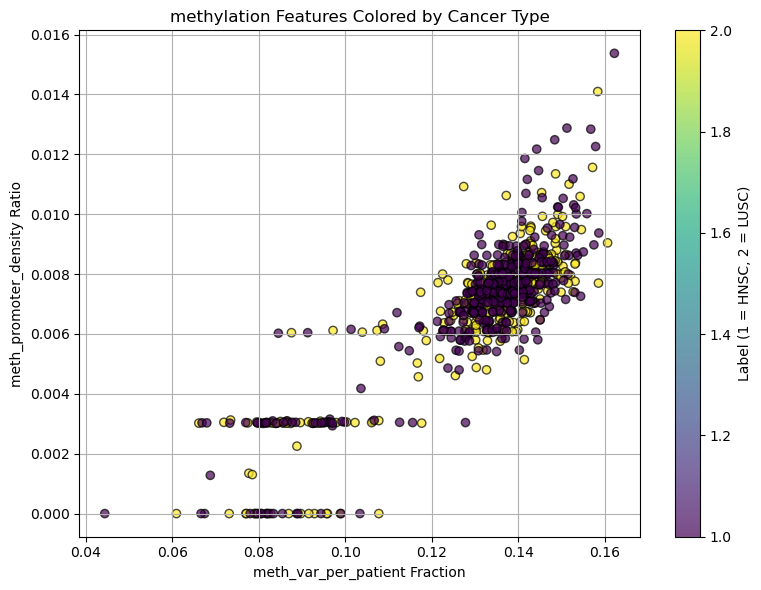

In [16]:
import matplotlib.pyplot as plt

train_basic_features = build_methylation_basic_features(train_df)
train_extra_features = build_methylation_extra_features(train_df, train_basic_features)

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_extra_features['meth_var_per_patient'],
    train_extra_features['meth_promoter_density'],
    c=labels,
    cmap='viridis',  # or 'coolwarm', 'plasma', etc.
    alpha=0.7,
    edgecolors='k'
)

plt.xlabel('meth_var_per_patient Fraction')
plt.ylabel('meth_promoter_density Ratio')
plt.title('methylation Features Colored by Cancer Type')
plt.colorbar(scatter, label='Label (1 = HNSC, 2 = LUSC)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Section d - Fitting the Data

In [17]:
clf = RandomForestClassifierWrapper(use_pca=False, n_components=100)
clf.fit(x_train, y_train)

### Section e - Validation Set Error
✅ The result are great!

In [18]:
df_known_test = pd.DataFrame({
    "predict_label": clf.predict(x_val),
    "Label": y_val
})
error = sum(df_known_test["Label"] != df_known_test["predict_label"]) / len(df_known_test)
print(f"Validation Error Rate: {error:.4f}")

Validation Error Rate: 0.3540


### Section f - Test set

In [19]:
test_df = pd.read_csv(METH_TEST_FILE)

test_basic_features = build_methylation_basic_features(test_df)
test_extra_features = build_methylation_extra_features(test_df, test_basic_features)

given_features = pd.read_csv(TEST_FEATURE_FILE)
given_features = given_features.select_dtypes(include=["number"])

test_extra_features = pd.concat([
    given_features.reset_index(drop=True),
    test_extra_features.reset_index(drop=True)
], axis=1)

missing_cols = [col for col in x_train.columns if col not in test_extra_features.columns]
filled_missing = pd.DataFrame(0, index=test_extra_features.index, columns=missing_cols)

test_extra_features = pd.concat([test_extra_features, filled_missing], axis=1)
test_extra_features = test_extra_features[x_train.columns]

pred = clf.predict(test_extra_features)

label_map = {1: "HNSC", 2: "LUSC"}
pred_named = pred.map(label_map)

case_ids = test_df["case_id"].unique()

predicted_df = pd.DataFrame({"case_id": case_ids,
                             "predicted_label": pred_named.values})
print(predicted_df.head(10))


                                case_id predicted_label
0  03b57fee-55c7-4873-b7ef-e29abd98863a            HNSC
1  0425cb44-66af-4e25-afcb-cacccc2f1179            HNSC
2  044579ef-16a6-4f00-b951-edc423d8a14f            HNSC
3  05d4d9c7-fb6f-439a-bb97-f0e2737a7773            HNSC
4  0858c8b7-e2eb-4461-b65e-9d476029ad8d            HNSC
5  0ab8d063-62b4-4d47-82aa-e3351a60029d            HNSC
6  0cca2b84-62bb-41c6-a65d-c27e4e98af78            HNSC
7  0de19185-3517-4e30-925b-7eb1f5079ec2            HNSC
8  0e515ab8-99f9-43d9-a621-8fe9ede828ec            HNSC
9  0f25d7fd-fc7c-4563-a8bd-80b5e0c32ea2            HNSC


Save the predictions in CVS:


In [20]:
import os

os.makedirs(PREDICTION_DIR, exist_ok=True)

output_path = os.path.join(PREDICTION_DIR, "predictions2.csv")
predicted_df.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")

Predictions saved to: C:\Users\danie\PycharmProjects\computational_genomic\predictions\predictions2.csv
